In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import validation_curve, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score, f1_score, log_loss,\
classification_report, roc_curve, confusion_matrix

RND_STATE = 777

In [12]:
datasets_path = ["Train_wo_na.csv", "Valid_wo_na.csv", "Control_wo_na.csv"]

train = pd.read_csv(fr'Data\{datasets_path[0]}', encoding='cp1251', index_col = 0).copy()
valid = pd.read_csv(fr'Data\{datasets_path[1]}', encoding='cp1251', index_col = 0).copy()
test = pd.read_csv(fr'Data\{datasets_path[2]}', encoding='cp1251', index_col = 0).copy()

In [13]:
cat_cols = train.dtypes[train.dtypes == 'object'].index

train_label = pd.get_dummies(train, columns=cat_cols, drop_first=True)
valid_label = pd.get_dummies(valid, columns=cat_cols, drop_first=True)
test_label = pd.get_dummies(test, columns=cat_cols, drop_first=True)

In [14]:
X_train = train_label.drop('open_account_flg', axis=1)
y_train = train_label['open_account_flg']

X_valid = valid_label.drop('open_account_flg', axis=1)
y_valid = valid_label['open_account_flg']

X_test = test_label.drop('open_account_flg', axis=1)
y_test = test_label['open_account_flg']

Сейчас мы посмотрим как работают деревья решений и так называемые ансамблевые методы, когда применяется несколько деревьев и проводится голосование. Два основных типа ансамблей - бэггинг и бустинг. 

Бэггинг предполагает создание нескольких деревьев. Каждое дерево тренируется на наборе данных, который извлечен из наших базовых наборов путем отбора наблюдений и признаков.

Бустинг предполагает также создание нескольких деревьев. Но деревья тренируются не параллельно, а последовательно. Причем на каждом последующем шаге учитываются результаты предыдущего. 

Рекомендую ознакомиться с этими методами по книге Практическая статистика для специалистов Data Science (Питер Брюс, Эндрю Брюс). Хороший материал по деревьям [здесь](https://loginom.ru/blog/decision-tree-p1)

In [15]:
tree_metrics = pd.DataFrame(index=['roc-auc', 'roc-auc_oob', 'precision',
                                 'recall', 'f1', 'logloss'])

# Модель на основе решающего дерева

In [16]:
def make_tree_classifier(x_train, y_train, x_valid, y_valid, results_df, model_name,
                         model_type, parameters={'min_samples_leaf':20}):
    model_types={
        'tree':DecisionTreeClassifier,
        'RF':RandomForestClassifier
    }
    
    model = model_types[model_type](**parameters,
                                     class_weight = 'balanced',
                                     random_state=RND_STATE)
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_valid)
    y_score = model.predict_proba(x_valid)[:,1]
    
    roc_auc_oob = roc_auc_score(y_train, model.oob_decision_function_[:, 1])\
    if model_type == 'RF' else np.NaN
    
    results_df[model_name] = [roc_auc_score(y_valid, y_score),
                              roc_auc_oob,
                              precision_score(y_valid, y_pred),
                              recall_score(y_valid, y_pred),
                              f1_score(y_valid, y_pred),
                              log_loss(y_valid, y_pred)]
    
    fpr_baseline, tpr_baseline, thresholds = roc_curve(y_valid, y_score)

    roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

    plt.plot(fpr_baseline, tpr_baseline, color='orange',
             label=f'ROC curve (area = {roc_auc_baseline:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('Tree-based classifier ROC AUC')
    plt.legend(loc="lower right")
    plt.show()
    return model

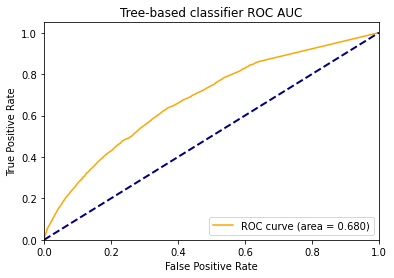

In [17]:
basic_tree = make_tree_classifier(x_train=X_train,
                                  y_train=y_train,
                                  x_valid=X_valid,
                                  y_valid=y_valid,
                                  results_df=tree_metrics,
                                  model_name='basic_tree',
                                  model_type='tree')

In [18]:
tree_metrics

,basic_tree
roc-auc,0.679725
roc-auc_oob,NaN
precision,0.274826
recall,0.602880
f1,0.377546
logloss,12.085777


<AxesSubplot:>

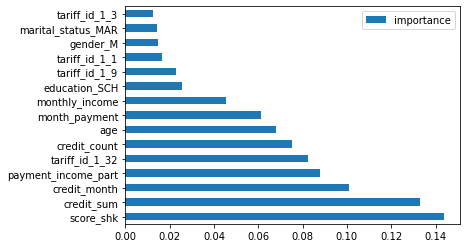

In [19]:
feat_imp_basic_tree = pd.DataFrame(index=X_train.columns, columns=['importance'], data=basic_tree.feature_importances_)
feat_imp_basic_tree.sort_values('importance', ascending=False)[:15].plot(kind='barh')

# Модель на основе случайного леса

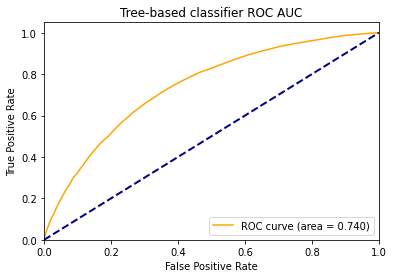

In [20]:
basic_RF = make_tree_classifier(x_train=X_train,
                                y_train=y_train,
                                x_valid=X_valid,
                                y_valid=y_valid,
                                results_df=tree_metrics,
                                model_name='basic_RF',
                                model_type='RF',
                                parameters={'n_jobs':-1,
                                            'max_features':'sqrt',
                                            'oob_score':True})

In [21]:
tree_metrics

,basic_tree,basic_RF
roc-auc,0.679725,0.739555
roc-auc_oob,NaN,0.730259
precision,0.274826,0.509485
recall,0.602880,0.093362
f1,0.377546,0.157806
logloss,12.085777,6.058388


<AxesSubplot:>

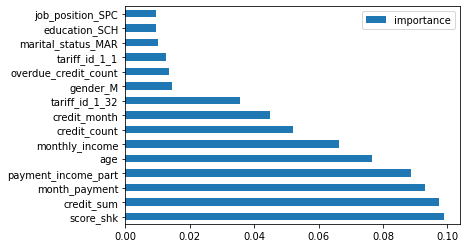

In [22]:
feat_imp_basic_RF = pd.DataFrame(index=X_train.columns,
                                 columns=['importance'],
                                 data=basic_RF.feature_importances_)
feat_imp_basic_RF.sort_values('importance', ascending=False)[:15].plot(kind='barh')

## Увеличим количество деревьев, но срежем глубину

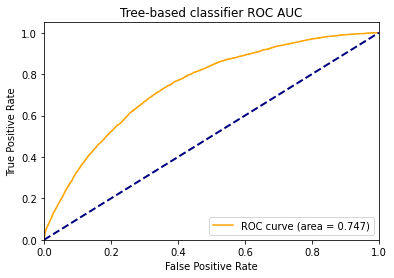

In [23]:
basic_RF_1000 = make_tree_classifier(x_train=X_train,
                                     y_train=y_train,
                                     x_valid=X_valid,
                                     y_valid=y_valid,
                                     results_df=tree_metrics,
                                     model_name='basic_RF_1000',
                                     model_type='RF',
                                     parameters={'n_jobs':-1,
                                                 'max_features':'sqrt',
                                                 'oob_score':True,
                                                 'n_estimators':1000,
                                                 'max_depth':20})

In [24]:
tree_metrics

,basic_tree,basic_RF,basic_RF_1000
roc-auc,0.679725,0.739555,0.746538
roc-auc_oob,NaN,0.730259,0.749184
precision,0.274826,0.509485,0.359080
recall,0.602880,0.093362,0.519450
f1,0.377546,0.157806,0.424628
logloss,12.085777,6.058388,8.558340


###  Эффект значений гиперпараметра (количества деревьев в RF)
На данном этапе постараемся разобраться в том, как результативность модели изменяется по мере изменения значений некоторого гиперпараметра. Для этого построим график валидационной кривой.

In [61]:
train_scores, test_scores = validation_curve(RandomForestClassifier(max_features='sqrt',
                                                                    random_state=RND_STATE,
                                                                    class_weight = 'balanced'),
                                             X_train,
                                             y_train,
                                             param_name='n_estimators',
                                             param_range=np.arange(100, 2000, 100),
                                             cv=3,
                                             scoring='roc_auc',
                                             n_jobs=-1)

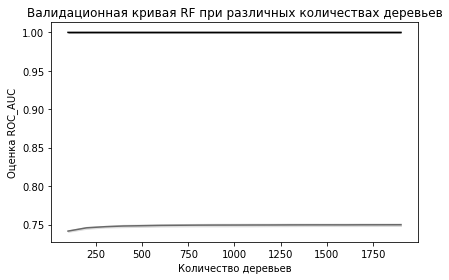

In [62]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
# Вычислить среднее и стандартное отклонение для оценок
# тестового набора
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
# Построить график средних оценок точности
# для тренировочного и тестового наборов
plt.plot(np.arange(100, 2000, 100), train_mean, color="black",
         label="Тренировочная оценка")
plt.plot(np.arange(100, 2000, 100), test_mean, color="dimgrey",
         label="Перекрестно-проверочная оценка")

# Нанести полосы точности для тренировочного и тестового наборов
plt.fill_between(np.arange(100, 2000, 100), train_mean - train_std,
                 train_mean + train_std, color="gray")
plt.fill_between(np.arange(100, 2000, 100), test_mean - test_std,
                 test_mean + test_std, color="gainsboro")

plt.title("Валидационная кривая RF при различных количествах деревьев")
plt.xlabel("Количество деревьев")
plt.ylabel("Оценка ROC_AUC")
plt.tight_layout()

Можно заметить, что при увеличении количества деревьев свыше 750 не происходит значительного улучшения значений целевой метрики.

In [47]:
rf_grid = {
    'n_estimators': np.arange(500, 1200, 100),
    'max_features': ['auto', 'sqrt'],
    'max_depth': np.append(np.linspace(10, 60, 6), [None]),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [48]:
rf = RandomForestClassifier(class_weight='balanced')

strat_cv = StratifiedKFold(n_splits=3,
                           shuffle=True)

rf_tuned = GridSearchCV(estimator=rf,
                        param_grid=rf_grid,
                        scoring='roc_auc',
                        cv = strat_cv,
                        verbose=5,
                        n_jobs=6)

In [49]:
!telegram-send 'RF random_grid fit started'

In [50]:
%%time
rf_tuned.fit(X_train, y_train)

Fitting 3 folds for each of 1764 candidates, totalling 5292 fits


C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.7451495  0.74564276 0.74548747 ... 0.75644738 0.75649748 0.75655381]
  warnings.warn(


Wall time: 3d 2h 2min 4s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=6,
             param_grid={'bootstrap': [True, False],
                         'max_depth': array([10.0, 20.0, 30.0, 40.0, 50.0, 60.0, None], dtype=object),
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': array([ 500,  600,  700,  800,  900, 1000, 1100])},
             scoring='roc_auc', verbose=5)

In [51]:
!telegram-send 'RF random_grid fit done'

In [52]:
RF_best_params = rf_tuned.best_params_

In [55]:
print(RF_best_params)

{'bootstrap': True, 'max_depth': 60.0, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 900}


In [58]:
RF_best_params = {
    'bootstrap': True,
    'max_depth': 60.0,
    'max_features': 'sqrt',
    'min_samples_leaf': 4,
    'min_samples_split': 10,
    'n_estimators': 900,
    'oob_score':True,
    'n_jobs':6}

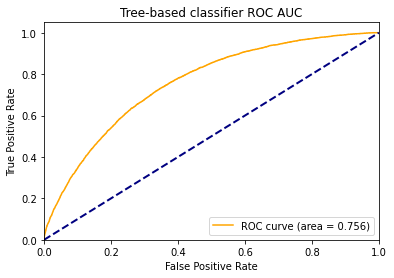

In [59]:
tuned_RF = make_tree_classifier(x_train=X_train,
                                y_train=y_train,
                                x_valid=X_valid,
                                y_valid=y_valid,
                                results_df=tree_metrics,
                                model_name='tuned_RF',
                                model_type='RF',
                                parameters=RF_best_params)

In [60]:
tree_metrics

,basic_tree,basic_RF,basic_RF_1000,tuned_RF
roc-auc,0.679725,0.739555,0.746538,0.756434
roc-auc_oob,NaN,0.730259,0.749184,0.759853
precision,0.274826,0.509485,0.359080,0.365477
recall,0.602880,0.093362,0.519450,0.540805
f1,0.377546,0.157806,0.424628,0.436182
logloss,12.085777,6.058388,8.558340,8.499972
